# Loan Eligibility Problem

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn.metrics import  confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
import lightgbm as lgm
from lightgbm import LGBMClassifier

In [2]:
lp = pd.read_csv('LoansTrainingSetV2.csv')

In [3]:
dfb=lp.copy()

In [4]:
dfb['Maximum Open Credit']=dfb['Maximum Open Credit'].replace({'#VALUE!':np.nan})

In [5]:
dfb['Monthly Debt']=dfb['Monthly Debt'].replace({'$1,051.41 ':'1051.41','$157.15 ':'157.15','$944.70 ':'944.7','$481.34 ':'481.34','$1,838.98 ':'1838.98','$471.60 ':'471.6'})

In [6]:
dfb['Monthly Debt']=dfb['Monthly Debt'].astype(float)

dfb['Maximum Open Credit']=dfb['Maximum Open Credit'].fillna(dfb['Maximum Open Credit'].median())

In [7]:
dfb['Monthly Debt']=dfb['Monthly Debt'].astype(float)

In [8]:
dfb['Tax Liens'] = dfb['Tax Liens'].astype('object')
dfb['Tax Liens'] = dfb['Tax Liens'].fillna(dfb['Tax Liens'].mode()[0])

In [9]:
dfb['Bankruptcies'] = dfb['Bankruptcies'].astype('object')
dfb['Bankruptcies'] = dfb['Bankruptcies'].fillna(dfb['Bankruptcies'].mode()[0])

In [10]:
dfb=dfb.drop('Months since last delinquent',axis=1)

In [11]:
mice_imputer= IterativeImputer(initial_strategy='median',imputation_order='random',random_state=3)

In [12]:
df2=dfb[['Credit Score','Annual Income']]

In [13]:
df2.iloc[:,:]=np.round(mice_imputer.fit_transform(df2))

In [14]:
df1=dfb.drop(columns=['Credit Score','Annual Income'],axis=1)

In [15]:
result= pd.concat([df1,df2], axis=1)

In [16]:
result['Credit Score']=result[result['Credit Score']<=800]['Credit Score']
result['Credit Score']= result['Credit Score'].fillna(800)

In [17]:
result['Tax Liens'] = result['Tax Liens'].astype('object')

In [18]:
result['Bankruptcies'] = result['Bankruptcies'].astype('object')

In [19]:
num_cols1 = result.select_dtypes(['float64','int64']).columns

In [20]:
skewed_features = result[num_cols1].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})  

In [21]:
# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()

In [22]:
#Create Empty list 
l_opt = {}

#create for loop for skewness.index
for feat in skewness.index:
    result[feat], l_opt[feat] = boxcox((result[feat]+1))

In [23]:
#create skewed_features2 for skewness.index
skewed_features2 = result[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2}) 

In [24]:
result['Credit Score']=np.log1p(result['Credit Score'])

In [25]:
result['Purpose']=result['Purpose'].replace({'other':'Other'})

In [26]:
result['Loan Status']=result['Loan Status'].replace({'Charged Off': 0,'Fully Paid': 1 })

In [27]:
result['Term']=result['Term'].replace({'Short Term': 0, 'Long Term': 1})

In [28]:
result = result.drop(['Loan ID','Customer ID'],axis=1)

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
dfff=pd.get_dummies(data=result,columns=['Years in current job','Home Ownership','Purpose','Tax Liens'],drop_first=True)

In [31]:
X=dfff.drop(['Loan Status','Bankruptcies','Number of Credit Problems','Home Ownership_Home Mortgage','Purpose_Debt Consolidation'],axis=1)
y=dfff['Loan Status']
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=3)

In [32]:
dfff=pd.get_dummies(data=result,columns=['Years in current job','Home Ownership','Purpose','Tax Liens'],drop_first=True)

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [34]:
bestfeatures = SelectKBest(score_func=f_classif, k=11)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfpvalue= pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfpvalue,dfscores],axis=1)
featureScores.columns = ['Specs','pvalue','Score']  #naming the dataframe columns
print(featureScores.nlargest(11,'Score'))  #print 11 best features

                             Specs         pvalue        Score
7                     Credit Score   0.000000e+00  2098.335911
0              Current Loan Amount  1.956683e-241  1108.884137
1                             Term  1.430870e-203   932.398339
8                    Annual Income   7.768290e-65   289.650614
20             Home Ownership_Rent   5.625156e-41   179.912543
3          Years of Credit History   1.182054e-16    68.670357
31          Purpose_small_business   1.676954e-15    63.438242
22               Purpose_Buy a Car   2.297375e-07    26.769978
24       Purpose_Home Improvements   7.679145e-07    24.440706
9   Years in current job_10+ years   5.042902e-06    20.823844
4          Number of Open Accounts   4.791803e-05    16.530611


In [35]:
signi_cols=list(featureScores.nlargest(11,'Score')['Specs'].values)
signi_cols

['Credit Score',
 'Current Loan Amount',
 'Term',
 'Annual Income',
 'Home Ownership_Rent',
 'Years of Credit History',
 'Purpose_small_business',
 'Purpose_Buy a Car',
 'Purpose_Home Improvements',
 'Years in current job_10+ years',
 'Number of Open Accounts']

In [36]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [37]:
X=dfff[signi_cols]
y=dfff['Loan Status']
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=3)

In [38]:
from sklearn.utils import resample 
randomoversampled_data  = pd.concat([X_train, y_train], axis=1)

In [39]:
majority = randomoversampled_data[randomoversampled_data["Loan Status"]==1] 
minority = randomoversampled_data[randomoversampled_data["Loan Status"]==0]  
minority_randomoversampled = resample(minority, replace=True ,n_samples=51182 ,random_state=2)  
del(randomoversampled_data) 
randomoversampled_data = pd.concat([majority,minority_randomoversampled])

In [40]:
X=dfff[signi_cols]
y=dfff['Loan Status']
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=3)

In [41]:
X_trains= randomoversampled_data.drop('Loan Status', axis=1)
y_trains= randomoversampled_data['Loan Status']

In [42]:
rsearch_lgbm_best_params={'criterion':'gini', 'max_depth': 6,'max_features': 2,'min_samples_leaf': 4,'min_samples_split': 7,'n_estimators': 90,
                          'objective':'binary'}

confusion matrix:
 [[29269 21913]
 [11447 48766]]
AUC-train: 0.7875386231859068
confusion matrix:
 [[ 4060  3552]
 [ 5272 20449]]
AUC-test: 0.7535504300840277


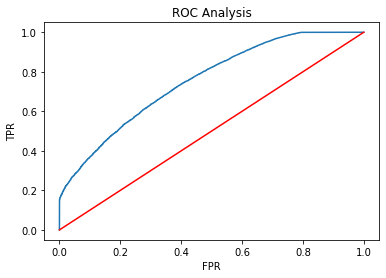



classification report - Train 
                precision    recall  f1-score   support

           0       0.72      0.57      0.64     51182
           1       0.69      0.81      0.75     60213

    accuracy                           0.70    111395
   macro avg       0.70      0.69      0.69    111395
weighted avg       0.70      0.70      0.70    111395

classification report - Test 
               precision    recall  f1-score   support

           0       0.44      0.53      0.48      7612
           1       0.85      0.80      0.82     25721

    accuracy                           0.74     33333
   macro avg       0.64      0.66      0.65     33333
weighted avg       0.76      0.74      0.74     33333



In [43]:
lgbm= LGBMClassifier(**rsearch_lgbm_best_params)

lgbm.fit(X_trains,y_trains)

train_pred=lgbm.predict(X_trains)
train_prob=lgbm.predict_proba(X_trains)[:,1]

train_prob


print('confusion matrix:\n',confusion_matrix (y_trains,train_pred))

print('AUC-train:',roc_auc_score(y_trains,train_prob))

test_pred=lgbm.predict(X_test)
test_prob=lgbm.predict_proba(X_test)[:,1]

print('confusion matrix:\n',confusion_matrix (y_test,test_pred))
print('AUC-test:',roc_auc_score(y_test,test_prob))

fpr, tpr, thresholds = roc_curve(y_test, test_prob)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Analysis')
plt.show()
print('\n')
print('classification report - Train \n ', classification_report(y_trains,train_pred))
print('classification report - Test \n', classification_report(y_test,test_pred))

In [44]:
import xgboost as xgb
from xgboost import XGBClassifier

In [45]:
gsearch_xgb_best_params={'criterion': 'gini','max_depth': 6,'min_samples_leaf': 1,'min_samples_split': 2,'n_estimators': 90}

overall accuracy -Train:  0.7476278109430405
confusion matrix:
 [[33178 18004]
 [10109 50104]]
AUC-train: 0.8428009515849464
overall accuracy -Test:  0.7338973389733897
confusion matrix:
 [[ 3933  3679]
 [ 5191 20530]]
AUC-test: 0.7456335378079784


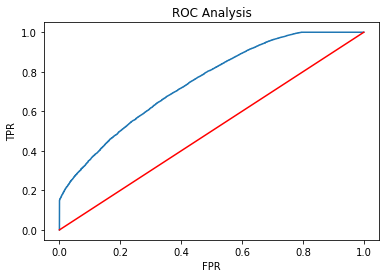



classification report - Train 
                precision    recall  f1-score   support

           0       0.77      0.65      0.70     51182
           1       0.74      0.83      0.78     60213

    accuracy                           0.75    111395
   macro avg       0.75      0.74      0.74    111395
weighted avg       0.75      0.75      0.74    111395

classification report - Test 
               precision    recall  f1-score   support

           0       0.43      0.52      0.47      7612
           1       0.85      0.80      0.82     25721

    accuracy                           0.73     33333
   macro avg       0.64      0.66      0.65     33333
weighted avg       0.75      0.73      0.74     33333



In [46]:
xgbm= xgb.XGBClassifier(**gsearch_xgb_best_params)
xgbm.fit(X_trains,y_trains)

train_pred=xgbm.predict(X_trains)
train_prob=xgbm.predict_proba(X_trains)[:,1]

train_prob

print('overall accuracy -Train: ',accuracy_score(y_trains,train_pred))
print('confusion matrix:\n',confusion_matrix (y_trains,train_pred))

print('AUC-train:',roc_auc_score(y_trains,train_prob))

test_pred=xgbm.predict(X_test)
test_prob=xgbm.predict_proba(X_test)[:,1]
print('overall accuracy -Test: ',accuracy_score(y_test,test_pred))
print('confusion matrix:\n',confusion_matrix (y_test,test_pred))
print('AUC-test:',roc_auc_score(y_test,test_prob))

fpr, tpr, thresholds = roc_curve(y_test, test_prob)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Analysis')
plt.show()
print('\n')
print('classification report - Train \n ', classification_report(y_trains,train_pred))
print('classification report - Test \n', classification_report(y_test,test_pred))

In [51]:
from tkinter import *
from tkinter import ttk

root = Tk()
root.title('Loan Prediction System')
root.geometry('850x650')
root.configure(background="purple2")
var = StringVar()
label = Label( root, textvariable = var,font=('arial',20,'bold'),bd=20,background="purple2")
var.set('                                             Loan Prediction System')
label.grid(row=0,columnspan=6)

label_0 = ttk.Label(root, text ='Please Enter the Values',font=("Helvetica", 16),background="Purple3")
label_0.grid(row=10,column=0)

label_1 = ttk.Label(root, text ='Credit Score',font=("Helvetica", 16),background="Purple3")
label_1.grid(row=11,column=0)
    
Entry_1= Entry(root)
Entry_1.grid(row=11,column=1)

label_2 = ttk.Label(root, text ='Current Loan Amount',font=("Helvetica", 16),background="Purple3")
label_2.grid(row=12,column=0)
    
Entry_2 = Entry(root)
Entry_2.grid(row=12,column=1)
    
    
label_3 = ttk.Label(root, text ='Term, Short Term:0, Long Term:1',font=("Helvetica", 16),background="Purple3")
label_3.grid(row=13,column=0)
    
Entry_3 = Entry(root)
Entry_3.grid(row=13,column=1)

label_4 = ttk.Label(root, text ='Annual Income',font=("Helvetica", 16),background="Purple3")
label_4.grid(row=14,column=0)
    
Entry_4 = Entry(root)
Entry_4.grid(row=14,column=1)

label_5 = ttk.Label(root, text ='Home Ownership_Rent No:0, Yes:1',font=("Helvetica", 16),background="Purple3")
label_5.grid(row=15,column=0)
    
Entry_5 = Entry(root)
Entry_5.grid(row=15,column=1)


label_6 = ttk.Label(root, text ='Years of Credit History',font=("Helvetica", 16),background="Purple3")
label_6.grid(row=17,column=0)
    
Entry_6 = Entry(root)
Entry_6.grid(row=17,column=1)

Entry_7 = Entry(root)
Entry_7.grid(row=18,column=1)

label_7 = ttk.Label(root, text ='Purpose_small_business  No:0, Yes:1',font=("Helvetica", 16),background="Purple3")
label_7.grid(row=18,column=0)
    
Entry_8 = Entry(root)
Entry_8.grid(row=19,column=1)

label_8 = ttk.Label(root, text ='Purpose_Buy a Car No:0, Yes:1',font=("Helvetica", 16),background="Purple3")
label_8.grid(row=19,column=0)
    
Entry_9 = Entry(root)
Entry_9.grid(row=20,column=1)

label_9 = ttk.Label(root, text ='Purpose_Home Improvements No:0, Yes:1',font=("Helvetica", 16),background="Purple3")
label_9.grid(row=20,column=0)

Entry_10 = Entry(root)
Entry_10.grid(row=21,column=1)

label_10 = ttk.Label(root, text ='Years in current job_10+ years No:0, Yes:1',font=("Helvetica", 16),background="Purple3")
label_10.grid(row=21,column=0)

Entry_11 = Entry(root)
Entry_11.grid(row=22,column=1)

label_11 = ttk.Label(root, text = 'Number of Open Accounts',font=("Helvetica", 16),background="Purple3")
label_11.grid(row=22,column=0)
    


def predict():
    Cla = float(Entry_1.get())
    T = float(Entry_2.get())
    Md = float(Entry_3.get())
    Ych = float(Entry_4.get())
    Noa = float(Entry_5.get())
    Ncp = float(Entry_6.get())
    Ccb = float(Entry_7.get())
    Moc = float(Entry_8.get())
    Cs = float(Entry_9.get())
    Ycj = float(Entry_10.get())
    Ml= float(Entry_11.get())
    arr=np.array([[(Cla),(T),(Md),(Ych),(Noa),(Ncp),(Ccb),(Moc),(Cs),(Ycj),(Ml)]])
    out = lgbm.predict(arr)
    if out[0] == 0:
        output.delete(0,END)
        output.insert(0,'Candidate is eligible, Loan can be given')
        output.insert(0,'Congragulations,')
    else :
        output.delete(0,END)
        output.insert(0,'Loan is refused, Please pay the dues then Apply for Loan again')
        output.insert(0,'Sorry, ')

b1 = Button(root, text = 'predict',font=("Helvetica", 16),background="Purple3",command = predict)
b1.grid(row=24,column=0)
    

output = Entry(root, text='P',font=("Helvetica", 16), width=70)
output.grid(row=24,column=1)

root.mainloop()

In [48]:
Significant_K_Best_Features=['Credit Score','Current Loan Amount','Term','Annual Income', 'Home Ownership_Rent',
                             'Maximum Open Credit','Years of Credit History','Purpose_small_business',
                             'Purpose_Buy a Car','Purpose_Home Improvements']